In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

# Load datasets
df1 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months


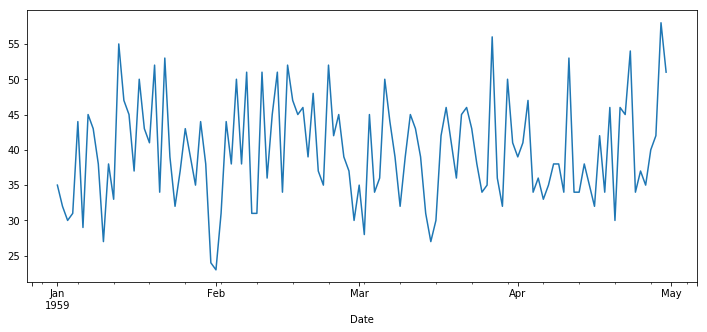

In [3]:
df1['Births'].plot(figsize=(12,5));

## Automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [2]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Run the augmented Dickey-Fuller Test to confirm stationarity

In [4]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Determine the (p,q) ARMA Orders using <tt>pmdarima.auto_arima</tt>
This tool should give just $p$ and $q$ value recommendations for this dataset.

In [5]:
auto_arima(df1['Births'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 2)   Log Likelihood                -405.370
Method:                       css-mle   S.D. of innovations              6.991
Date:                Sat, 23 Mar 2019   AIC                            822.741
Time:                        12:02:45   BIC                            839.466
Sample:                             0   HQIC                           829.533
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8162      0.108    368.841      0.000      39.605      40.028
ar.L1.y        1.8568      0.081     22.933      0.000       1.698       2.016
ar.L2.y       -0.8814      0.073    -12.030      0.000      -1.025      -0.738
ma.L1.y       -1.8634      0.109    -17.126      0.000      -2.077      -1.650
ma.L2.y        0.8634      0.108      8.020      0.000       0.652       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           -0.1582j            1.0652           -0.0237
AR.2            1.0533           +0.1582j            1.0652            0.0237
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1583           +0.0000j            1.1583            0.0000
-----------------------------------------------------------------------------
"""

### Split the data into train/test sets
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [6]:
# Set one month for testing
train = df1.iloc[:90]
test = df1.iloc[90:]

### Fit an ARMA(p,q) Model
If you want you can run <tt>help(ARMA)</tt> to learn what incoming arguments are available/expected, and what's being returned.

In [7]:
model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Sat, 23 Mar 2019   AIC                            627.809
Time:                        12:08:30   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

### Obtain a month's worth of predicted values

In [10]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

### Plot predictions against known values

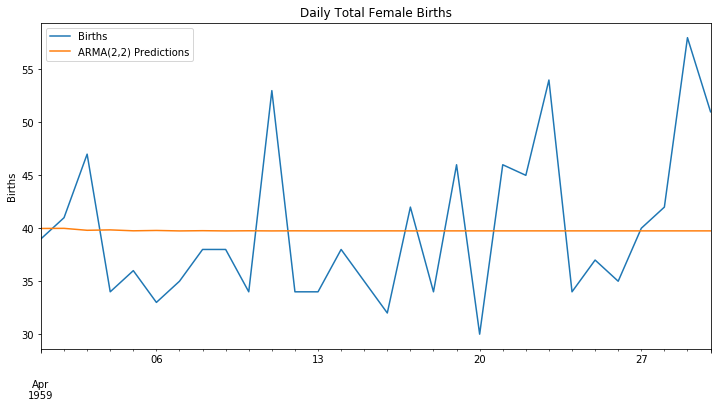

In [11]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. In the next section we'll take additional steps to evaluate the performance of our predictions, and forecast into the future.